## Импорты

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Загрузка данных

In [15]:
DATA_X = 'train_x.csv'
DATA_Y = 'train_y.csv'
TEST_X = 'test_x.csv'

if os.path.exists(DATA_X) and os.path.exists(DATA_Y) and os.path.exists(TEST_X):
    print('Найдены train_x.csv, train_y.csv и test_x.csv')
    df_x = pd.read_csv(DATA_X)
    df_y = pd.read_csv(DATA_Y)
    df_x = df_x.rename(columns={df_x.columns[0]: 'id'})
    df_y = df_y.rename(columns={df_y.columns[0]: 'id'})
    if 'year' not in df_y.columns:
        other = [c for c in df_y.columns if c != 'id'][0]
        df_y = df_y.rename(columns={other: 'year'})
    df = df_x.merge(df_y[['id', 'year']], on='id')
    df_test = pd.read_csv(TEST_X)
else:
    print('Файлы не найдены.')

Найдены train_x.csv, train_y.csv и test_x.csv


## Предобработка

In [ ]:
FEATURE_COLS = [c for c in df.columns if c not in ('id', 'year')]

X = df[FEATURE_COLS].values.astype(float)
y = df['year'].values.astype(float)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)

X_test = df_test[[c for c in df_test.columns if c != 'id']].values.astype(float)
X_test_s = scaler.transform(X_test)

Предобработка: стандартизация завершена.


## Dataset / DataLoader

In [18]:
class SongsDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) if y is not None else None
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

train_ds = SongsDataset(X_train_s, y_train)
val_ds = SongsDataset(X_val_s, y_val)

BATCH = 128
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

## Модель

In [19]:
class SimpleRegressor(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

model = SimpleRegressor(X_train_s.shape[1])
print(model)

SimpleRegressor(
  (net): Sequential(
    (0): Linear(in_features=90, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Кастомный оптимизатор: Adam

In [20]:
class CustomAdam:
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.0):
        self.params = [p for p in params if p.requires_grad]
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = [torch.zeros_like(p.data) for p in self.params]
        self.v = [torch.zeros_like(p.data) for p in self.params]
        self.t = 0
    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            g = p.grad.data
            if self.weight_decay != 0:
                g = g + self.weight_decay * p.data
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g * g)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            update = self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)
            p.data = p.data - update
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

## Обучение с выбором оптимизатора

In [21]:
def train_model(model: nn.Module, train_loader, val_loader, optimizer, epochs=30, device='cpu'):
    model.to(device)
    criterion = nn.MSELoss()
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs+1):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            preds = model(Xb)
            loss = criterion(preds, yb)

            # backward
            if isinstance(optimizer, CustomAdam):
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_losses.append(loss.item())

        # validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(device)
                yv = yv.to(device)
                vp = model(Xv)
                val_losses.append(criterion(vp, yv).item())

        train_loss = float(np.mean(train_losses))
        val_loss = float(np.mean(val_losses))
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch}/{epochs} — train MSE: {train_loss:.4f}, val MSE: {val_loss:.4f}")

    return history

## Torch Adam vs CustomAdam

Device: cpu
Epoch 1/200 — train MSE: 3854595.7756, val MSE: 3565412.7614
Epoch 2/200 — train MSE: 2977054.2273, val MSE: 2291179.4886
Epoch 3/200 — train MSE: 1564025.3771, val MSE: 915358.2472
Epoch 4/200 — train MSE: 504194.0842, val MSE: 196437.2053
Epoch 5/200 — train MSE: 104165.2563, val MSE: 45431.8491
Epoch 6/200 — train MSE: 27124.0640, val MSE: 4733.2802
Epoch 7/200 — train MSE: 17797.3804, val MSE: 1825.6129
Epoch 8/200 — train MSE: 16062.5689, val MSE: 2555.5922
Epoch 9/200 — train MSE: 14983.2417, val MSE: 3920.5368
Epoch 10/200 — train MSE: 14798.6511, val MSE: 2167.2342
Epoch 11/200 — train MSE: 13816.3548, val MSE: 1037.9075
Epoch 12/200 — train MSE: 13299.7511, val MSE: 1744.1172
Epoch 13/200 — train MSE: 13201.5208, val MSE: 2540.9786
Epoch 14/200 — train MSE: 13228.3870, val MSE: 2791.4263
Epoch 15/200 — train MSE: 13068.7620, val MSE: 1276.3753
Epoch 16/200 — train MSE: 12530.5746, val MSE: 1086.9946
Epoch 17/200 — train MSE: 12142.0647, val MSE: 2380.6900
Epoch 18/

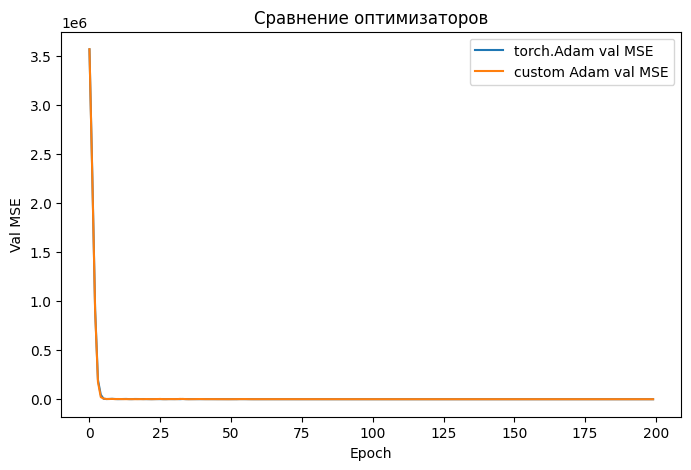

In [ ]:
EPOCHS = 200
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)

# стандартный Adam (torch.optim)
model1 = SimpleRegressor(X_train_s.shape[1])
opt1 = torch.optim.Adam(model1.parameters(), lr=1e-2, weight_decay=1e-5)
hist1 = train_model(model1, train_loader, val_loader, opt1, epochs=EPOCHS, device=DEVICE)

# кастомный Adam
model2 = SimpleRegressor(X_train_s.shape[1])
opt2 = CustomAdam(model2.parameters(), lr=1e-2, weight_decay=1e-5)
hist2 = train_model(model2, train_loader, val_loader, opt2, epochs=EPOCHS, device=DEVICE)

# плот кривых
plt.figure(figsize=(8,5))
plt.plot(hist1['val_loss'], label='torch.Adam val MSE')
plt.plot(hist2['val_loss'], label='custom Adam val MSE')
plt.xlabel('Epoch')
plt.ylabel('Val MSE')
plt.legend()
plt.title('Сравнение оптимизаторов')
plt.show()

In [ ]:
model_final = model2
model_final.to(DEVICE)
model_final.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_s, dtype=torch.float32).to(DEVICE)
    preds = model_final(X_test_t).cpu().numpy()
preds_year = np.rint(preds).astype(int)
submission = pd.DataFrame({'id': df_test['id'].values, 'year': preds_year})
submission.to_csv('submission_custom_adam.csv', index=False)
print('Сохранён файл submission_custom_adam.csv')

Сохранён файл submission_custom_adam.csv
